In [49]:
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt
import math

### set parameters and physical values

In [50]:
ig = 7            # 
grid = 128        # number of computational grids (must be 2^ig)
step_end = 200    # number of time steps
step_out = 20     # interval of output
length = 256.e-09 # length of computationa domain [m]
dt = 0.02         # time increment [dimensionless time]

In [51]:
temp = 355.       # temperature [K]
mobility = 1.0    # mobility of phase-field
vm0 = 7.0e-6      # molar volume [m3/mol]
aa = 0.15         # constant A for chemical free energy
bb = 3.*aa+12.    # constant B for chemical free energy
cc = 2.*aa+12.    # constant C for chemical free energy

In [52]:
pi = 3.141592     # pi
rr = 8.3145       # gas 
stress_unit=(1.0e+11)*vm0/rr/temp # stress is regularized by this number

In [53]:
c11=stress_unit*1.40   # elastic constant: C11=140GPa
c22=c11
c33=c11
c44=stress_unit*0.28   # C44=(C11-C12)/2 because of isotropic material
c55=c44
c66=c44
c12=stress_unit*0.84   # C12=84GPa
c21=c12
c13=c12
c31=c12
c23=c12
c32=c12
ram0=c12               # Lame's constant lambda
mu0=c44                # Lame's constant mu
nu0=ram0/2./(ram0+mu0) # Poisson's ratio
munu0=2.*mu0*(1.-nu0)
sig22_a=0.             # applied stress along y direction
# sig22_a=2.e+06*vm0/rr/temp
ep11_a=-c12/(c11-c12)/(c11+2.*c12)*sig22_a # applied strain due to the applied stress
ep22_a=(c11+c12)/(c11-c12)/(c11+2.*c12)*sig22_a

In [54]:
ndm = grid-1
half_grid = int(grid/2)
dx = length/grid  # spacing of computational grids
aa0 = (3.5e+08*(405.-temp)/405.)*vm0/rr/temp  # magnitude of driving force [dimensionless]
grad_energ_coeff=(1.0e-15)/rr/temp/dx/dx      # gradient energy coefficient [dimensionless]

In [55]:
# Declaration of arrays and variables for phase field model

p1 = np.zeros((grid,grid)) # phase-field variables 1
p2 = np.zeros((grid,grid)) # phase-field variables 2
eigen11_r = np.zeros((grid,grid)) # eigen strain in real space
eigen22_r = np.zeros((grid,grid)) # eigen strain in real space
eigen12_r = np.zeros((grid,grid))
eigen21_r = np.zeros((grid,grid))

# real and imagenary part of eigen strain in fourier space
eigen11_f_real = np.zeros((grid,grid)) 
eigen11_f_imag = np.zeros((grid,grid))
eigen22_f_real = np.zeros((grid,grid)) 
eigen22_f_imag = np.zeros((grid,grid)) 
eigen12_f_real = np.zeros((grid,grid))
eigen12_f_imag = np.zeros((grid,grid))
eigen21_f_real = np.zeros((grid,grid))
eigen21_f_imag = np.zeros((grid,grid))

# inhomogeneous strains
inhomo_strain11 = np.zeros((grid,grid))
inhomo_strain22 = np.zeros((grid,grid))
inhomo_strain12 = np.zeros((grid,grid))
inhomo_strain21 = np.zeros((grid,grid))

# Cauchy stress
stress11 = np.zeros((grid,grid))
stress22 = np.zeros((grid,grid))
stress33 = np.zeros((grid,grid))
stress12 = np.zeros((grid,grid))

# elastic strain
elastic_strain11 = np.zeros((grid,grid))
elastic_strain22 = np.zeros((grid,grid))
elastic_strain12 = np.zeros((grid,grid))
elastic_strain21 = np.zeros((grid,grid))

# eigen strain for each variants
eigen0_1 = np.zeros((4,4))
eigen0_2 = np.zeros((4,4))

In [56]:
# Declaration of arrays and variables for Fourier transform

# imagenary and real part of variable to be transformed
xi = np.zeros((grid,grid))
xr = np.zeros((grid,grid))

# imagenary and real part of variable to be inverse transformed
xif = np.zeros((grid*grid))
xrf = np.zeros((grid*grid))

s = np.zeros((grid)) # sin
c = np.zeros((grid)) # cos
ik = [0] * grid

In [57]:
# input eigen strain for each variant
#eigen0_1 = 0
#eigen0_2 = 0
eigen0_1[0,0]=-0.1994 # eigen strain for variant 1 (phase field 1)
eigen0_1[1,1]= 0.1322
eigen0_2[0,0]= 0.1322 # eigen strain for variant 2 (phase field 2)
eigen0_2[1,1]=-0.1994

In [58]:
# setting initial distribution of phase-field variable
for i in range(ndm):
  for j in range(ndm):
    p1[i,j]=int(rand()*grid)       # rand() generates random numbers ranging from 0 to 1
    p2[i,j]=1-p1[i,j]

In [59]:
def sincos(pi,ig,grid,half_grid,c,s,ik):  # pi, grid, half_grid -> c,s,ik
  q=2.0*pi/grid
  for it in range(half_grid):
    c[it]=np.cos(q*it)
    s[it]=np.sin(q*it)
  
  ik[0]=0
  mn=half_grid
  mc=1
  for it1 in range(ig):
    for it2 in range(mc):
      ik[it2+mc]=ik[it2]+mn
    mn=mn/2
    mc=2*mc

In [60]:
sincos(pi,ig,grid,half_grid,c,s,ik)

In [61]:
# 1-dimensional FFT
def fft1(qs,grid,ig,half_grid,xrf,xif,c,s):
  l2=1
  for lf in range(ig):
    n2=int(half_grid/l2)
    for mf in range(1,l2+1):
      for nf in range(n2):
        ix=nf*l2
        ka=nf+2*n2*(mf-1)
        kb=ka+n2
        tr=xrf[ka]-xrf[kb]
        tj=xif[ka]-xif[kb]
        xrf[ka]=xrf[ka]+xrf[kb]
        xif[ka]=xif[ka]+xif[kb]
        xrf[kb]=tr*c[ix]+tj*qs*s[ix]
        xif[kb]=tj*c[ix]-tr*qs*s[ix]
    l2=l2*2

In [62]:
# Fast Fourier transformation
def fft(qs,ig,grid,half_grid,ndm,c,s,ik,xr,xi):
  for ir in range(ndm):
    for ic in range(ndm):
      xrf[ic]=xr[ir,ic]
      xif[ic]=xi[ir,ic]
    fft1(qs,grid,ig,half_grid,xrf,xif,c,s)
    for ic in range(ndm):
      xr[ir,ic]=xrf[int(ik[ic])]
      xi[ir,ic]=xif[int(ik[ic])]

  for ic in range(ndm):
    for ir in range(ndm):
      xrf[ir]=xr[ir,ic]
      xif[ir]=xi[ir,ic]
    fft1(qs,grid,ig,half_grid,xrf,xif,c,s)
    for ir in range(ndm):
      xr[ir,ic]=xrf[int(ik[ir])]
      xi[ir,ic]=xif[int(ik[ir])]

  if (qs <= 0):  # if forward FFT, return
    # if inverse FFT, the resutls must be divided by total number of grids
    for i in range(ndm):
      for j in range(ndm):
        xr[i,j]=xr[i,j]/grid/grid
        xi[i,j]=xi[i,j]/grid/grid

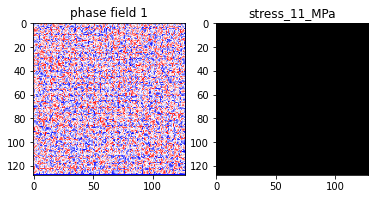

In [63]:
# file output of results
plt.subplot(1,2, 1)
plt.imshow(p1[:,:], cmap='bwr')
plt.title('phase field 1')

#plt.subplot(1,2, 2)
#plt.imshow(p2[:,:], cmap='bwr')
#plt.title('phase field 2')

plt.subplot(1,2, 2)
plt.imshow(stress11/(1.e6*vm0/rr/temp), cmap="gray")
plt.title('stress_11_MPa') # unit of stress [MPa]

#plt.subplot(1,2, 2)
#plt.imshow(stress22/(1.e6*vm0/rr/temp), cmap="gray")
#plt.title('stress_22_MPa') # unit of stress [MPa]

#plt.subplot(1,2, 2)
#plt.imshow(stress33/(1.e6*vm0/rr/temp), cmap="gray")
#plt.title('stress_33_MPa') # unit of stress [MPa]

#plt.subplot(1,2, 2)
#plt.imshow(stress12/(1.e6*vm0/rr/temp), cmap="gray")
#plt.title('stress_12_MPa') # unit of stress [MPa]

#plt.colorbar()
plt.show()

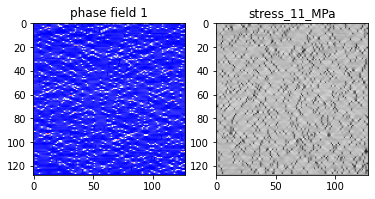

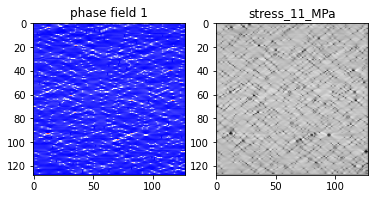

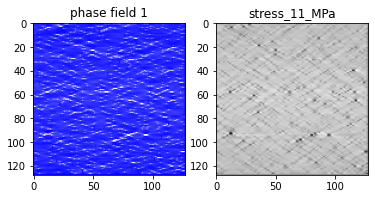

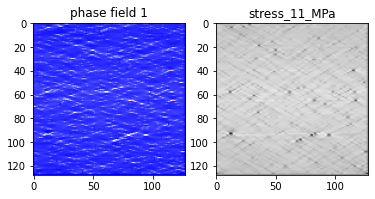

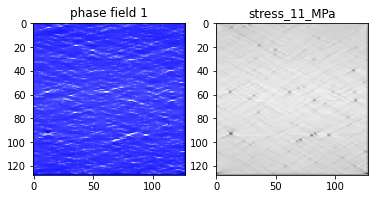

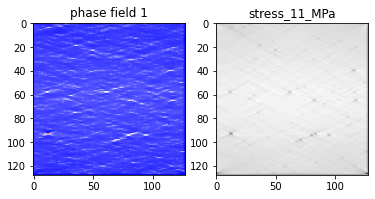

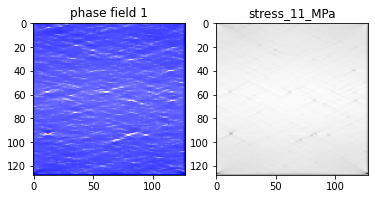

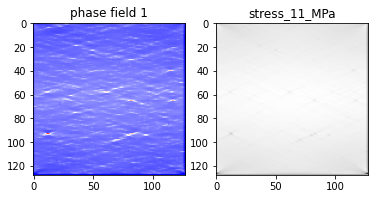

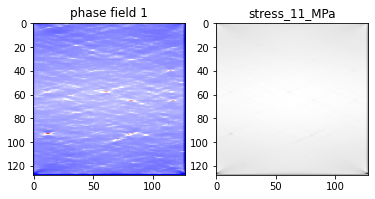

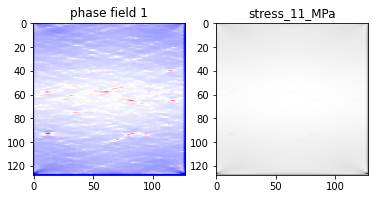

In [64]:
# Main program

# start iteration
for nstep in range(1,step_end+1):

  # calculation of eigen strain 11 and Fourier transform
  for i in range(ndm):
    for j in range(ndm):
      xr[i,j]=eigen0_1[1,1]*p1[i,j]+eigen0_2[1,1]*p2[i,j] # see Eq.(8.8)
      xi[i,j]=0.0
      eigen11_r[i,j]=xr[i,j]

  F = np.fft.fft2((xr + xi * 1j))
  eigen11_f_real = F.real
  eigen11_f_imag = F.imag
  #fft(-1,ig,grid,half_grid,ndm,c,s,ik,xr,xi) # forward FFT

  #for i in range(ndm):
  #  for j in range(ndm):
  #    eigen11_f_real[i,j]=xr[i,j] # real part of eigen strain in Fourier space
  #    eigen11_f_imag[i,j]=xi[i,j]
  eigen11_f_real[0,0]=0.0
  eigen11_f_imag[0,0]=0.0

  # calculation of eigen strain 22 and Fourier transform
  for i in range(ndm):
    for j in range(ndm):
      xr[i,j]=eigen0_1[2,2]*p1[i,j]+eigen0_2[2,2]*p2[i,j]
      xi[i,j]=0.0
      eigen22_r[i,j]=xr[i,j]

  F = np.fft.fft2((xr + xi * 1j))
  eigen22_f_real = F.real
  eigen22_f_imag = F.imag
  #fft(-1,ig,grid,half_grid,ndm,c,s,ik,xr,xi)

  #for i in range(ndm):
  #  for j in range(ndm):
  #    eigen22_f_real[i,j]=xr[i,j]
  #    eigen22_f_imag[i,j]=xi[i,j]
  eigen22_f_real[0,0]=0.0
  eigen22_f_imag[0,0]=0.0

  # calculation of eigen strain 12 and Fourier transform
  for i in range(ndm):
    for j in range(ndm):
      xr[i,j]=eigen0_1[1,2]*p1[i,j]+eigen0_2[1,2]*p2[i,j]
      xi[i,j]=0.0
      eigen12_r[i,j]=xr[i,j]

  F = np.fft.fft2((xr + xi * 1j))
  eigen12_f_real = F.real
  eigen12_f_imag = F.imag
  #fft(-1,ig,grid,half_grid,ndm,c,s,ik,xr,xi)

  #for i in range(ndm):
  #  for j in range(ndm):
  #    eigen12_f_real[i,j]=xr[i,j]
  #    eigen12_f_imag[i,j]=xi[i,j]
  eigen12_f_real[0,0]=0.0
  eigen12_f_imag[0,0]=0.0
  eigen21_f_real = eigen12_f_real  # strain tensor is symmetry
  eigen21_f_imag = eigen12_f_imag

  # calculation of homogeneous strain (this program assumes free surface)
  sum11=0.0
  sum22=0.0
  sum12=0.0
  sum21=0.0
  for i in range(ndm):
    for j in range(ndm):
      sum11=sum11+eigen11_r[i,j]
      sum22=sum22+eigen22_r[i,j]
      sum12=sum12+eigen12_r[i,j]
      sum21=sum21+eigen21_r[i,j]
  # homogeneous strain is volume average of eigen strain in this program, see Eq. (7.18)
  homo_strain11=sum11/grid/grid  
  homo_strain22=sum22/grid/grid
  homo_strain12=sum12/grid/grid
  homo_strain21=homo_strain12

  # calculation of inhomogeneous strain 11
  for i in range(ndm):
    if(i <= half_grid-1):
      ii=i
    if(i >= half_grid  ):
      ii=i-grid
    for j in range(ndm):
      if(j <= half_grid-1):
        jj=j
      if(j >= half_grid  ):
        jj=j-grid
      k_mag=ii*ii+jj*jj
      nnn=np.sqrt(k_mag) # magnutude of wave vector |k|
      if(nnn == 0.0):
        nnn=1.0
      kxx=(ii/nnn)*(ii/nnn)
      kyy=(jj/nnn)*(jj/nnn)
      kxy=(ii/nnn)*(jj/nnn)
      # calculation of eigen stress (see Eq.(7.30))
      sigma11_r=ram0*(eigen11_f_real[i,j]+eigen22_f_real[i,j])+2.0*mu0*eigen11_f_real[i,j]
      sigma22_r=ram0*(eigen11_f_real[i,j]+eigen22_f_real[i,j])+2.0*mu0*eigen22_f_real[i,j]
      sigma12_r= mu0*(eigen12_f_real[i,j]+eigen21_f_real[i,j])
      sigma11_i=ram0*(eigen11_f_imag[i,j]+eigen22_f_imag[i,j])+2.0*mu0*eigen11_f_imag[i,j]
      sigma22_i=ram0*(eigen11_f_imag[i,j]+eigen22_f_imag[i,j])+2.0*mu0*eigen22_f_imag[i,j]
      sigma12_i= mu0*(eigen12_f_imag[i,j]+eigen21_f_imag[i,j])
      # real part of inhomogeneous strain in Fourier space
      xr[i,j]=(kxx*(1.0/mu0-kxx/munu0)*sigma11_r-kxy*kxy/munu0*sigma22_r
              +kxy*(1.0/mu0-kxx/munu0)*sigma12_r-kxy*kxx/munu0*sigma12_r)
      # imagenary part of inhomogeneous strain in Fourier space
      xi[i,j]=(kxx*(1.0/mu0-kxx/munu0)*sigma11_i-kxy*kxy/munu0*sigma22_i
              +kxy*(1.0/mu0-kxx/munu0)*sigma12_i-kxy*kxx/munu0*sigma12_i)

  IFF = np.fft.ifft2((xr + xi * 1j))
  inhomo_strain11 = IFF.real
  #IFF.imag
  #fft(1,ig,grid,half_grid,ndm,c,s,ik,xr,xi) # inverse FFT

  #inhomo_strain11 = xr # inhomogeneous strain in real space

  # calculation of inhomogeneous strain 22
  for i in range(ndm):
    if(i <= half_grid-1):
      ii=i
    if(i >= half_grid  ):
      ii=i-grid
    for j in range(ndm):
      if(j <= half_grid-1):
        jj=j
      if(j >= half_grid  ):
        jj=j-grid
      k_mag=ii*ii+jj*jj
      nnn=np.sqrt(k_mag)
      if(nnn == 0.0):
        nnn=1.0
      kxx=(ii/nnn)*(ii/nnn)
      kyy=(jj/nnn)*(jj/nnn)
      kxy=(ii/nnn)*(jj/nnn)
      sigma11_r=ram0*(eigen11_f_real[i,j]+eigen22_f_real[i,j])+2.0*mu0*eigen11_f_real[i,j]
      sigma22_r=ram0*(eigen11_f_real[i,j]+eigen22_f_real[i,j])+2.0*mu0*eigen22_f_real[i,j]
      sigma12_r= mu0*(eigen12_f_real[i,j]+eigen21_f_real[i,j])
      sigma11_i=ram0*(eigen11_f_imag[i,j]+eigen22_f_imag[i,j])+2.0*mu0*eigen11_f_imag[i,j]
      sigma22_i=ram0*(eigen11_f_imag[i,j]+eigen22_f_imag[i,j])+2.0*mu0*eigen22_f_imag[i,j]
      sigma12_i= mu0*(eigen12_f_imag[i,j]+eigen21_f_imag[i,j])
      xr[i,j]=(-kxy*kxy/munu0*sigma11_r+kyy*(1.0/mu0-kyy/munu0)*sigma22_r
               -kxy*kyy/munu0*sigma12_r+kxy*(1.0/mu0-kyy/munu0)*sigma12_r)
      xi[i,j]=(-kxy*kxy/munu0*sigma11_i+kyy*(1.0/mu0-kyy/munu0)*sigma22_i
               -kxy*kyy/munu0*sigma12_i+kxy*(1.0/mu0-kyy/munu0)*sigma12_i)

  IFF = np.fft.ifft2((xr + xi * 1j))
  inhomo_strain22 = IFF.real
  #IFF.imag
  #fft(1,ig,grid,half_grid,ndm,c,s,ik,xr,xi)

  #inhomo_strain22 = xr

  # calculation of inhomogeneous strain 12
  for i in range(ndm):
    if(i <= half_grid-1):
      ii=i 
    if(i >= half_grid  ):
      ii=i-grid
    for j in range(ndm):
      if(j <= half_grid-1):
        jj=j
      if(j >= half_grid  ):
        jj=j-grid 
      k_mag=ii*ii+jj*jj
      nnn=np.sqrt(k_mag)
      if(nnn == 0.0):
        nnn=1.0
      kxx=(ii/nnn)*(ii/nnn)
      kyy=(jj/nnn)*(jj/nnn)
      kxy=(ii/nnn)*(jj/nnn)
      sigma11_r=ram0*(eigen11_f_real[i,j]+eigen22_f_real[i,j])+2.0*mu0*eigen11_f_real[i,j]
      sigma22_r=ram0*(eigen11_f_real[i,j]+eigen22_f_real[i,j])+2.0*mu0*eigen22_f_real[i,j]
      sigma12_r= mu0*(eigen12_f_real[i,j]+eigen21_f_real[i,j])
      sigma11_i=ram0*(eigen11_f_imag[i,j]+eigen22_f_imag[i,j])+2.0*mu0*eigen11_f_imag[i,j]
      sigma22_i=ram0*(eigen11_f_imag[i,j]+eigen22_f_imag[i,j])+2.0*mu0*eigen22_f_imag[i,j]
      sigma12_i= mu0*(eigen12_f_imag[i,j]+eigen21_f_imag[i,j])
      xr[i,j]=(kxy*(1.0/2.0/mu0-kxx/munu0)*sigma11_r+(1.0/2.0/mu0*kxy-kyy*kxy/munu0)*sigma22_r
              +kyy*(1.0/2.0/mu0-kxx/munu0)*sigma12_r+(1.0/2.0/mu0*kxx-kxy*kxy/munu0)*sigma12_r)
      xi[i,j]=(kxy*(1.0/2.0/mu0-kxx/munu0)*sigma11_i+(1.0/2.0/mu0*kxy-kyy*kxy/munu0)*sigma22_i
              +kyy*(1.0/2.0/mu0-kxx/munu0)*sigma12_i+(1.0/2.0/mu0*kxx-kxy*kxy/munu0)*sigma12_i)

  IFF = np.fft.ifft2((xr + xi * 1j))
  inhomo_strain12 = IFF.real
  #IFF.imag
  #fft(1,ig,grid,half_grid,ndm,c,s,ik,xr,xi)

  #inhomo_strain12 = xr
  inhomo_strain21 = inhomo_strain12

  # calculation of Cauchy stress
  for i in range(ndm):
    for j in range(ndm):
      stress11[i,j]=((ram0+2.0*mu0)*(homo_strain11+inhomo_strain11[i,j]-eigen11_r[i,j])
                   +ram0*(homo_strain22+inhomo_strain22[i,j]-eigen22_r[i,j])) # Cauchy stress 11
      stress22[i,j]=(ram0*(homo_strain11+inhomo_strain11[i,j]-eigen11_r[i,j])
                   +(ram0+2.0*mu0)*(homo_strain22+inhomo_strain22[i,j]-eigen22_r[i,j]))
      stress33[i,j]=(ram0*((homo_strain11+inhomo_strain11[i,j]-eigen11_r[i,j])
                   +(homo_strain22+inhomo_strain22[i,j]-eigen22_r[i,j])))
      stress12[i,j]=(mu0*((homo_strain12+inhomo_strain12[i,j]-eigen12_r[i,j])
                   +(homo_strain21+inhomo_strain21[i,j]-eigen21_r[i,j])))

      elastic_strain11[i,j]=homo_strain11+inhomo_strain11[i,j]+ep11_a-eigen11_r[i,j] # elastic strain 11
      elastic_strain22[i,j]=homo_strain22+inhomo_strain22[i,j]+ep22_a-eigen22_r[i,j]
      elastic_strain12[i,j]=homo_strain12+inhomo_strain12[i,j]-eigen12_r[i,j]
      elastic_strain21[i,j]=elastic_strain12[i,j]

  # calculation of potentials (derivatives each energy density w.r.t. phase field variable)
  for i in range(ndm):
    for j in range(ndm):
      ip=i+1
      im=i-1
      jp=j+1
      jm=j-1
      if(i == ndm):
        ip=0  # periodic boundary condition is assumed
      if(i == 0  ):
        im=ndm
      if(j == ndm):
        jp=0
      if(j == 0  ):
        jm=ndm

      # potential for gradient energy
      grad_pot1=-grad_energ_coeff*(p1[ip,j]+p1[im,j]+p1[i,jp]+p1[i,jm]-4.0*p1[i,j])
      grad_pot2=-grad_energ_coeff*(p2[ip,j]+p2[im,j]+p2[i,jp]+p2[i,jm]-4.0*p2[i,j])

      # potential for chemical free energy
      s1=p1[i,j]
      s2=p2[i,j]
      chem_pot1=aa0*s1*(aa-bb*s1+cc*(s1*s1+s2*s2))
      chem_pot2=aa0*s2*(aa-bb*s2+cc*(s1*s1+s2*s2))

      # potential for elastic strain energy (see Eq.(7.39))
      eigen11_p1=eigen0_1[1,1]
      eigen22_p1=eigen0_1[2,2]
      eigen11_p2=eigen0_2[1,1]
      eigen22_p2=eigen0_2[2,2]
      el_strain11= -elastic_strain11[i,j]
      el_strain22= -elastic_strain22[i,j]
      elast_pot1=(ram0*(el_strain11+el_strain22)*(eigen11_p1+eigen22_p1)
                +2.0*mu0*(el_strain11*eigen11_p1+el_strain22*eigen22_p1))
      elast_pot2=(ram0*(el_strain11+el_strain22)*(eigen11_p2+eigen22_p2)
                +2.0*mu0*(el_strain11*eigen11_p2+el_strain22*eigen22_p2))

      # calculation of right hand side of Allen-Cahn equation (see Eq.(8.11))
      dpdt1=-mobility*(chem_pot1+grad_pot1+elast_pot1)
      dpdt2=-mobility*(chem_pot2+grad_pot2+elast_pot2)

      # time integration of phase field variables
      p1[i,j]=p1[i,j]+dpdt1*dt
      p2[i,j]=p2[i,j]+dpdt2*dt

      # adjust phase-field variables within 0~1
      if(p1[i,j] >= 1.0):
        p1[i,j]=1.0
      if(p1[i,j] <= 0.0):
        p1[i,j]=0.0
      if(p2[i,j] >= 1.0):
        p2[i,j]=1.0
      if(p2[i,j] <= 0.0):
        p2[i,j]=0.0

  # output result
  if((nstep % step_out) == 0):
    plt.subplot(1,2, 1)
    plt.imshow(p1[:,:], cmap='bwr')
    plt.title('phase field 1')
    #
    plt.subplot(1,2, 2)
    plt.imshow(stress11/(1.e6*vm0/rr/temp), cmap="gray")
    plt.title('stress_11_MPa') # unit of stress [MPa]
    #
    #plt.colorbar()
    plt.show()